In [63]:
%%capture
!pip install scikit-posthocs

## 1. Environment Setup

First, we'll import the necessary Python libraries for data manipulation, statistical analysis, and visualization. We are also installing `scikit-posthocs` for advanced statistical testing later in the analysis.



In [64]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Executive Summary

This report presents a comprehensive analysis of the Google Play Store dataset to uncover key factors driving app success, focusing on user ratings, number of installs, and app category.

Methodology: The project involved a rigorous data cleaning and imputation process. A critical challenge was a corrupted data row, which was identified and removed. Missing Rating and Size values were not missing at random; a Kruskal-Wallis test confirmed a statistically significant difference in their distributions across app categories (p < 0.05). Consequently, a context-aware imputation strategy using category-specific medians was employed.

Key Findings:

1. App category seems to play a significant role on performance. 'GAME' and 'COMMUNICATION' apps dominate in total installations, while 'HEALTH_AND_FITNESS', 'BOOKS_AND_REFERENCE' and 'EVENTS' apps achieve statistically higher user ratings.

2. The 'Dating' Anomaly: The 'DATING' category consistently exhibits statistically lower user ratings than nearly all other categories, suggesting a unique market dynamic or user expectation gap.

3. Installs Correlate with Reviews: A strong positive correlation exists between the number of installs and the number of reviews, confirming that user engagement through reviews grows with an app's user base.

## 2. Data Loading and Initial Inspection

The first step in any data analysis project is to load the data and perform a high-level inspection. This helps us understand the dataset's structure, the data types of each column, and get a preliminary look at the data itself.

In [65]:
# Load the dataset from the CSV file into a pandas DataFrame
df = pd.read_csv('googleplaystore.csv')

In [66]:
# Display the first 5 rows to get a feel for the data and its columns
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [67]:
# Get a concise summary of the DataFrame.
# This includes the number of non-null values and the data type of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Initial Observation: The .info() output shows that several columns, such as Rating, Current Ver and Android Ver, have fewer than 10841 non-null entries, indicating the presence of missing values. Additionally, columns that should be numeric like Reviews, Size, Installs, and Price are currently of the object data type. This tells us that data cleaning and type conversion will be necessary.

In [68]:
# Generate descriptive statistics for the numerical columns.
# Note: At this stage, only 'Rating' is numeric, so the output is limited.
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [69]:
# Get a count of missing values in each column to quantify the cleaning task ahead.
df.isnull().sum()

,0
App,0
Category,0
Rating,1474
Reviews,0
Size,0
Installs,0
Type,1
Price,0
Content Rating,1
Genres,0


## 3. Data Cleaning (First Pass)

Based on our initial inspection, the data requires significant cleaning. In this first pass, we will address the following issues based on our initial understanding of the data:
- Duplicated rows
- Incorrect data types (e.g., 'Reviews', 'Size')
- Special characters and non-numeric values in numeric columns


### 3.1 Handling Duplicated Rows

Duplicate entries can skew analysis and should be removed. We'll first count them and then drop them from the DataFrame.

In [70]:
# Count the total number of duplicated rows in the dataset
df.duplicated().sum()

np.int64(483)

In [71]:
# Remove the duplicated rows, keeping the first occurrence
df.drop_duplicates(inplace=True)

### 3.2 Cleaning and Converting Columns

Next, we will iterate through the columns identified as having incorrect data types or special characters, converting them to a usable format.

#### Reviews Column

In [72]:
# The 'Reviews' column should be numeric, but is an 'object' type.
# Let's check for any non-numeric values that might be causing this.
df[~df['Reviews'].str.isnumeric()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


Observation: The check reveals a non-numeric value '3.0M' in the 'Reviews' column for the app at index 10472. This seems to be a data entry error where the 'M' for million was included. We will correct this specific entry.

In [73]:
# The non-numeric value appears to be '3.0M'. We will manually correct this to '3000000'.
# Note: This is our first encounter with the problematic row 10472.
df.loc[10472, 'Reviews'] = '3000000'

In [74]:
# Now that all values are numeric strings, we can safely convert the column to an integer type.
df['Reviews'] = df['Reviews'].astype(int)

#### Size Column
The `Size` column contains a mix of values in kilobytes ('k'), megabytes ('M'), and the string 'Varies with device'. We will standardize these to kilobytes (KB) and handle the special cases.


In [75]:
# Let's check how the data in this 'Size' column look like
df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [76]:
# At first sight we see that almost all sizes are expressed as Megabytes (M)
# and Kilobytes (k). There are two major issues. Values that are expressed as
# 'Varies with device' and '1,000+'.

# First we'll try to convert Megabytes to Kilobytes and handling the issues
# by applying a function.


# This function will parse the 'Size' string and convert it to a numeric value in KB.
# - It replaces 'Varies with device' with NaN (Not a Number) as the size is unknown.
# - It handles a specific outlier '1,000+' which appears to be a data entry error.
# - It converts 'M' (megabytes) to kilobytes by multiplying by 1000.
# - It removes 'k' from kilobyte values and converts to float.
def convert_to_kb(value):
  """
  Convert size string to kilobytes
  Handles cases like: '19M', '201k', 'Varies with device', '1,000+'
  """

  cases_with_issue = ['Varies with device']
  if value in cases_with_issue:
    return np.nan

  # In cases where value == '1,000+', replace it with 1 (1 Kilobyte)
  if value == '1,000+':
    return 1

  # Handle other cases
  if 'M' in value:
    number = float(value.replace('M', ''))
    return number * 1000
  elif 'k' in value:
    return float(value.replace('k', ''))
  else:
    return float(value)

In [77]:
# Apply the 'convert_to_kb' function to 'Size' column
df['Size'] = df['Size'].apply(convert_to_kb).round(2)

#### Installs and Price Columns
The `Installs` and `Price` columns contain special characters (like '+', ',', '$') that prevent them from being treated as numeric. We will remove these characters and convert the columns to the appropriate numeric types.

In [78]:
# Check for all the unique values in 'Installs' column
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0', 'Free'], dtype=object)

In [79]:
# Replace '+', ',' and 'Free' with '' and 0
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = df['Installs'].str.replace(',', '')
df['Installs'] = df['Installs'].str.replace('Free', '0')

In [80]:
# Convert 'Installs' column into integers
df['Installs'] = df['Installs'].astype(int)

In [81]:
# Check for all the unique values in 'Price' column
df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', 'Everyone', '$1.20', '$1.04'], dtype=object)

In [82]:
# Replace '$' and 'Everyone' with '' and '0' respectively
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].str.replace('Everyone', '0')

In [83]:
# Convert 'Price' column into floats
df['Price'] = df['Price'].astype(float)

#### Last Updated Column
This column will be converted to a proper datetime format, from which we can extract the day, month, and year for potential feature engineering.

In [84]:
# We first check for the unique values in 'Last Updated' column
df['Last Updated'].unique()

array(['January 7, 2018', 'January 15, 2018', 'August 1, 2018', ...,
       'January 20, 2014', 'February 16, 2014', 'March 23, 2014'],
      dtype=object)

In [85]:
# Let's check also for nan values
df['Last Updated'].isnull().sum()

np.int64(0)

In [86]:
# Convert the 'Last Updated' column to datetime objects.
# The `errors='coerce'` argument is crucial; it will turn any unparseable date strings into NaT (Not a Time).
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='mixed', errors='coerce')

In [87]:
# After that we create three new columns: 'Last_Updated_Day', 'Last_Updated_Month'
# and 'Last_Updated_Year'.
df['Last_Updated_Day'] = df['Last Updated'].dt.day.astype('Int64')
df['Last_Updated_Month'] = df['Last Updated'].dt.month.astype('Int64')
df['Last_Updated_Year'] = df['Last Updated'].dt.year.astype('Int64')

In [88]:
# And drop the 'Last Updated' column
df.drop('Last Updated', axis=1, inplace=True)

### Type

In [89]:
# Check the unique values in 'Type' feature
df['Type'].unique()

array(['Free', 'Paid', nan, '0'], dtype=object)

In [90]:
# As we can see there is also the '0' value which probably refers to 'free'
# Let's replace it with 'Free'
df['Type'] = df['Type'].str.replace('0', 'Free')

### 3.3 Investigating an Anomaly in the 'Category' Column

During our systematic cleaning, we perform a final check on the `Category` column, which should contain a fixed set of text values.

In [91]:
# Let's examine all unique values in the 'Category' column to ensure they are valid.
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [92]:
# The unique values reveal a highly unusual entry: '1.9'. This should not be a category.
# Let's isolate the row(s) containing this value to understand the context.
df[df['Category'] == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3000000,1.0,0,Free,0.0,NaN,"February 11, 2018",4.0 and up,NaN,<NA>,<NA>,<NA>


### 4. The Root Cause: A Corrupted Row

**Major Discovery:** The investigation into the anomalous '1.9' category leads us to row 10472. A closer look at this row reveals that it is the source of many of the data inconsistencies we've been manually fixing.

The data in this row appears to have been shifted one column to the left, starting from the `Category` column which is missing. This caused '1.9' (the `Rating`) to be read as the `Category`, '3.0M' (the `Reviews`) to be read as the `Rating`, and so on.

This explains the strange values we encountered:
- The non-numeric '3.0M' in the `Reviews` column.
- The 'Everyone' value in the `Price` column.
- The '1,000+' value in the `Size` column.

**Decision:** Instead of attempting a complex and potentially error-prone repair of this single row, the most robust and reliable solution is to discard it entirely. Given our large dataset, the removal of one row will have no statistical impact. We will now restart the cleaning process from a fresh load of the data, this time beginning by removing the corrupted row.

## 5. Final Data Cleaning and Preprocessing

Armed with the knowledge that row 10472 is the source of the data corruption, we will now perform a definitive cleaning pass on a freshly loaded dataset. The process is as follows:

1.  **Reload** the original dataset.
2.  **Remove** the corrupted row (10472) immediately.
3.  **Handle duplicates** based on App name, as this is the unique identifier for each application.
4.  **Clean and convert** data types for all relevant columns.
5.  **Investigate and impute** missing values in the `Rating` and `Size` columns using a statistically-backed strategy.
6.  **Handle the few remaining missing values** in other columns.

In [93]:
# Reload the original 'googleplaystore.csv' file to start with a clean slate.
df = pd.read_csv('googleplaystore.csv')

### 5.1 Removing Corrupted Data and Duplicates

In [94]:
# Immediately drop the identified corrupted row at index 10472.
df.drop(10472, inplace=True)

# Reset the index to ensure it is contiguous after dropping the row.
df.reset_index(drop=True, inplace=True)

In [95]:
# Remove duplicate entries based on the 'App' name.
# We choose to keep the 'first' occurrence, which typically represents the most recent entry.
df.drop_duplicates(subset='App', keep='first', inplace=True)

### 5.2 Column Cleaning and Type Conversion

Now that the primary data integrity issues are resolved, we can proceed with cleaning and converting the columns to their correct data types much more efficiently.

In [96]:
# Verify that the 'Reviews' column is now free of non-numeric values.
# The output is an empty DataFrame, confirming the column is clean.
df[~df['Reviews'].str.isnumeric()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


In [97]:
# Convert the 'Reviews' column from object to integer.
df['Reviews'] = df['Reviews'].astype(int)

In [98]:
# Define a simplified function to convert 'Size' to kilobytes (KB).
# This version no longer needs to handle the specific errors caused by row 10472.
def convert_to_kb(value):
  """
  Convert size string to kilobytes
  Handles cases like: '19M', '201k', 'Varies with device'
  """

  cases_with_issue = ['Varies with device']
  if value in cases_with_issue:
    return np.nan

  # Handle other cases
  if 'M' in value:
    number = float(value.replace('M', ''))
    return number * 1000
  elif 'k' in value:
    return float(value.replace('k', ''))
  else:
    return float(value)

# Apply the function and round to two decimal places.
df['Size'] = df['Size'].apply(convert_to_kb).round(2)

In [99]:
# By checking unique values in 'Installs' column we see that there is no longer
# the value 'Free'
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [100]:
# Clean the 'Installs' column by removing '+' and ',' and convert to integer.
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = df['Installs'].str.replace(',', '')
df['Installs'] = df['Installs'].astype(int)

In [101]:
# Clean the 'Price' column by removing '$' and convert to float.
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)

In [102]:
# Convert 'Last Updated' to datetime objects for easier analysis.
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [103]:
# Feature Engineering: Extract day, month, and year from 'Last Updated'.
# This allows for time-based analysis.
df['Last_Updated_Day'] = df['Last Updated'].dt.day.astype(int)
df['Last_Updated_Month'] = df['Last Updated'].dt.month.astype(int)
df['Last_Updated_Year'] = df['Last Updated'].dt.year.astype(int)

# Drop the original 'Last Updated' column as it's no longer needed.
df.drop('Last Updated', axis=1, inplace=True)

## 6. Missing Value Analysis and Imputation

After the initial cleaning, we are left with missing values primarily in the `Rating` and `Size` columns. Simply dropping these rows or filling them with a global mean/median could introduce bias. Therefore, we will first investigate *why* the data is missing and then apply a context-aware imputation strategy.

In [104]:
# Check the count of missing values now that the main cleaning is complete.
df.isnull().sum()

,0
App,0
Category,0
Rating,1463
Reviews,0
Size,1227
Installs,0
Type,1
Price,0
Content Rating,0
Genres,0


### 6.1 Investigating Missing Ratings

**Hypothesis:** Ratings are likely missing for new or unpopular apps that have not yet accumulated enough reviews or installs.

To test this, we will compare the descriptive statistics of apps *with* ratings versus those *without*.

In [105]:
# Create a DataFrame of apps where 'Rating' is null.
missing_rating_df = df[df['Rating'].isnull()]

# Display summary statistics for this group.
missing_rating_df[['Reviews', 'Installs', 'Price']].describe()

,Reviews,Installs,Price
count,1463.000000,1463.000000,1463.000000
mean,18.127136,4006.964457,1.443356
std,140.427100,40871.266489,16.821624
min,0.000000,0.000000,0.000000
25%,0.000000,10.000000,0.000000
50%,1.000000,100.000000,0.000000
75%,5.000000,500.000000,0.000000
max,3248.000000,1000000.000000,399.990000


In [106]:
# For comparison, create a DataFrame of apps that have a 'Rating'.
has_rating_df = df[df['Rating'].notnull()]

# Display summary statistics for this group.
has_rating_df[['Reviews', 'Installs', 'Price']].describe()

,Reviews,Installs,Price
count,8.196000e+03,8.196000e+03,8196.000000
mean,2.552515e+05,9.165090e+06,1.037884
std,1.985594e+06,5.825087e+07,16.857882
min,1.000000e+00,1.000000e+00,0.000000
25%,1.260000e+02,1.000000e+04,0.000000
50%,3.004000e+03,1.000000e+05,0.000000
75%,4.381300e+04,1.000000e+06,0.000000
max,7.815831e+07,1.000000e+09,400.000000


**Observation:** The descriptive statistics clearly support our hypothesis. The group of apps without ratings has a dramatically lower mean and median for both Reviews and Installs compared to the group with ratings. This confirms that the data is not missing at random, and a simple removal or global imputation would be inappropriate.

### 6.2 Justifying Imputation Strategy with Statistical Testing

Our next hypothesis is that the average rating differs significantly across app categories. If true, this would justify imputing missing ratings with the median rating of their specific category, which is a more accurate approach than using a single global value.

First, we visualize the distributions with a boxplot, sorted by median rating.


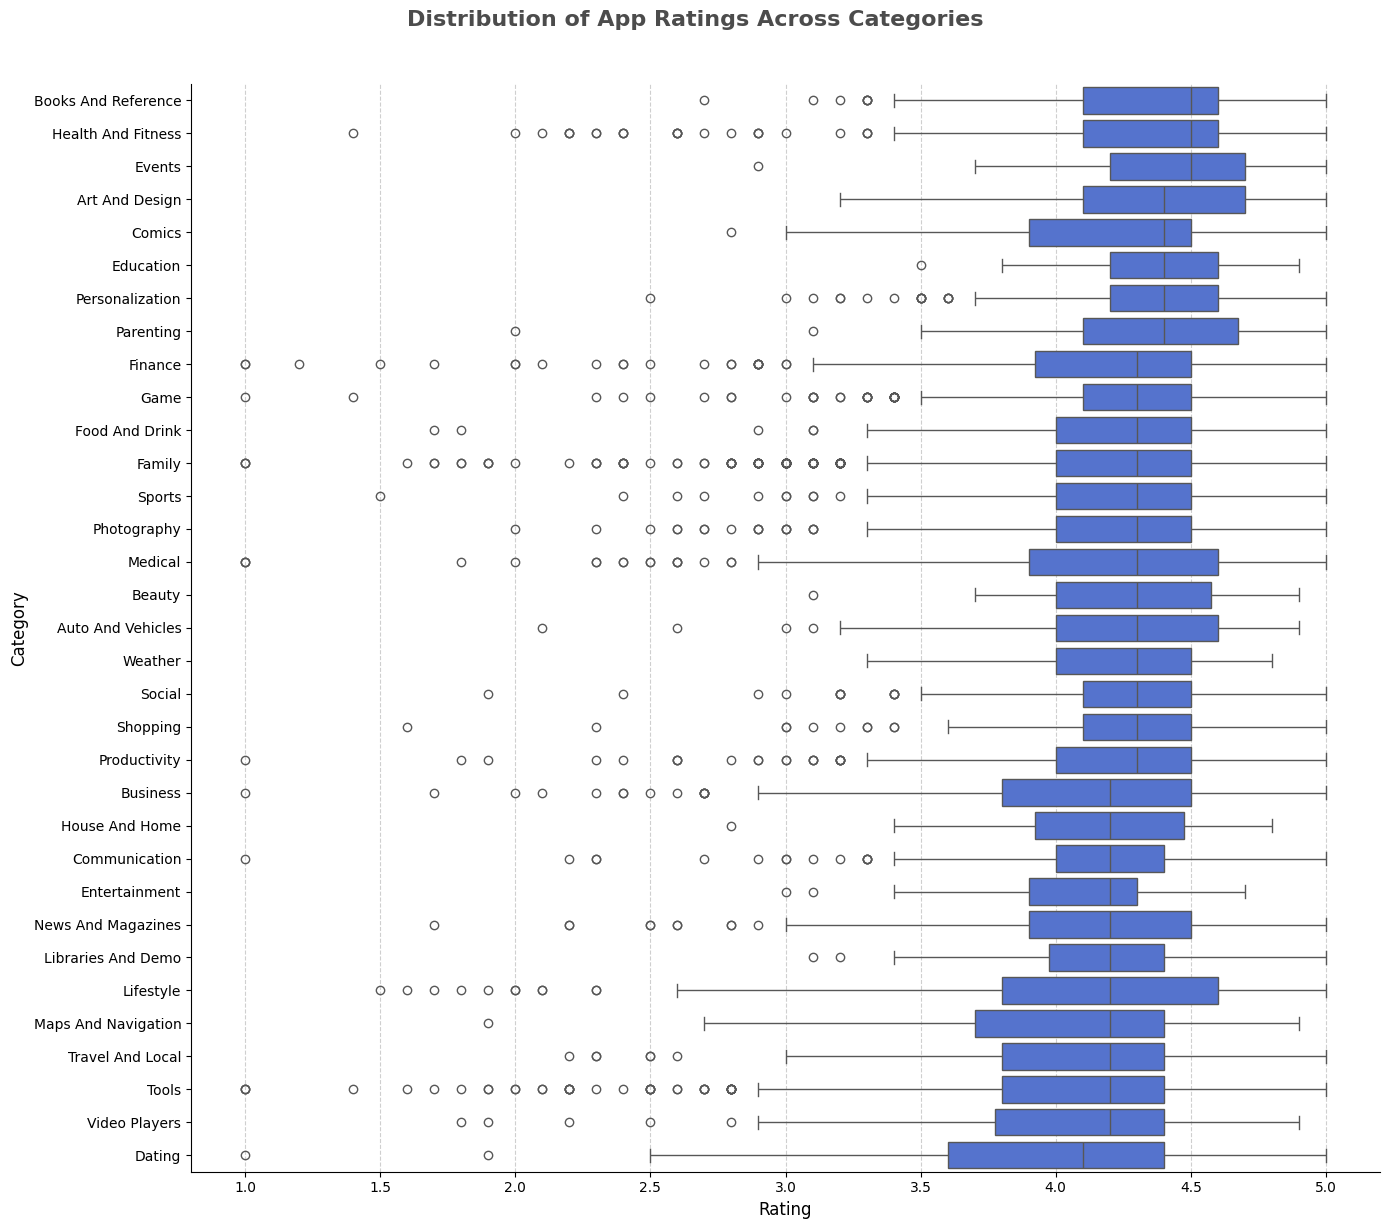

In [107]:
# Calculate the median rating for each category to create a sorted order for the plot.
category_order = df.dropna(subset=['Rating']).groupby('Category')['Rating'].median().sort_values(ascending=False).index

# Create the boxplot to visually inspect the distributions.
plt.figure(figsize=(14, 12))

sns.boxplot(
    data=df,
    x='Rating',
    y='Category',
    order=category_order,
    color='royalblue'
)

# Add some polish and formatting.
plt.suptitle(
    'Distribution of App Ratings Across Categories',
    fontsize=16,
    fontweight='bold',
    y=1.02,
    alpha=.7
)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()

ax = plt.gca()
tick_locations = ax.get_yticks()

formatted_labels = [label.replace('_', ' ').title() for label in category_order]

plt.yticks(ticks=tick_locations, labels=formatted_labels)

plt.tight_layout()
plt.show()

The boxplots provide a clear summary of the median and spread of ratings for each category. To get a more detailed view of the shape of these distributions, we can visualize them using Kernel Density Estimate (KDE) plots. This will help us see where ratings are most concentrated and if there are any unusual patterns before we proceed with statistical testing.

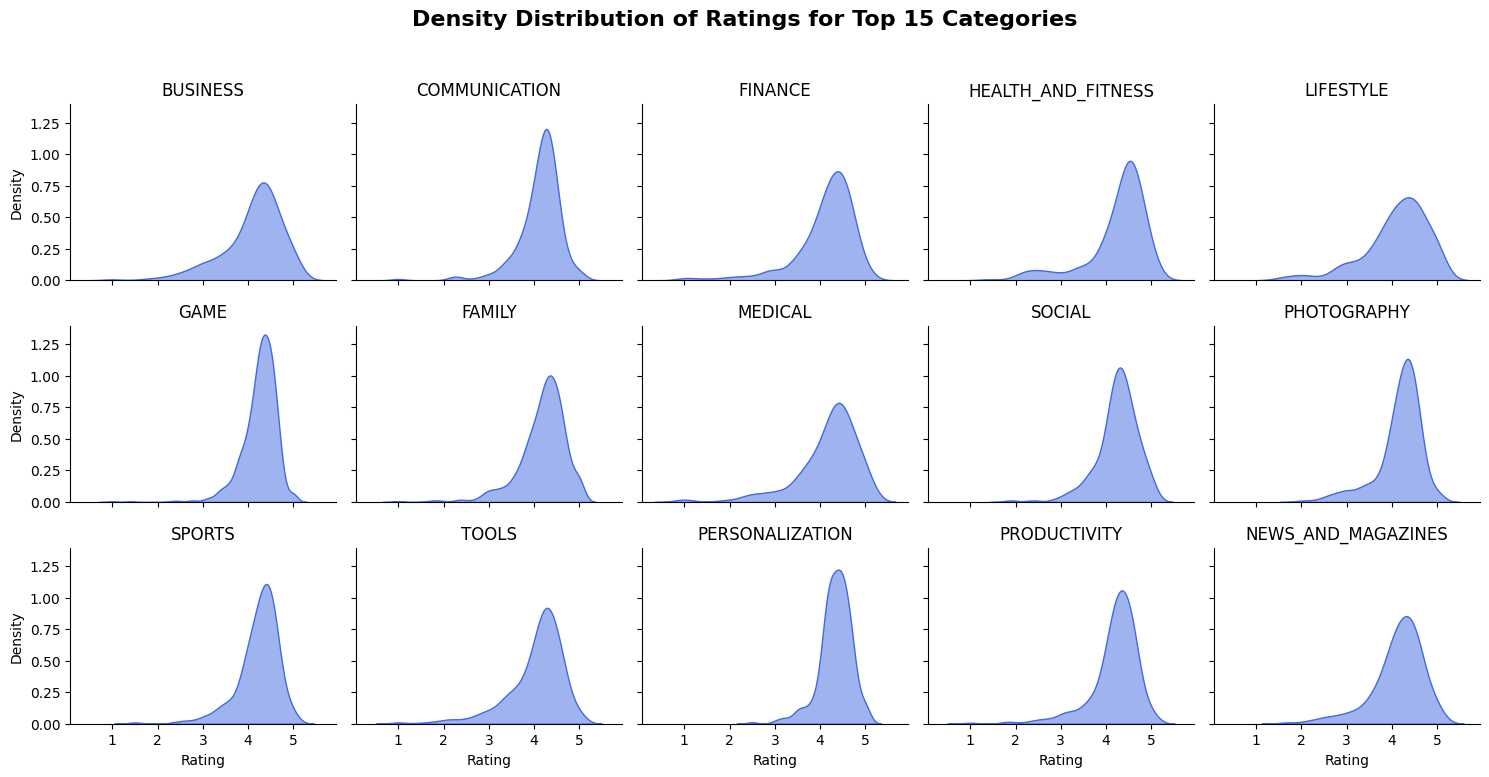

In [108]:
# For visual clarity, we'll focus on the top 15 categories by the number of apps.
top_categories = df['Category'].value_counts().nlargest(15).index

# Filter the DataFrame to only include these top categories.
df_top_cat = df[df['Category'].isin(top_categories)]

# Create a FacetGrid, which is ideal for creating a grid of similar plots.
# We'll arrange the plots in a grid with 5 columns.
g = sns.FacetGrid(df_top_cat, col="Category", col_wrap=5, height=2.5, aspect=1.2)

# Map a filled Kernel Density Estimate (KDE) plot onto each subplot of the grid.
# This provides a smooth representation of the rating distributions.
g.map(sns.kdeplot, "Rating", fill=True, alpha=0.5, color='royalblue')

# Add a descriptive super-title to the entire figure.
g.fig.suptitle('Density Distribution of Ratings for Top 15 Categories', y=1.03, fontsize=16, fontweight='bold')

# Set individual subplot titles to be the category name.
g.set_titles("{col_name}", size=12)

# Set the axis labels for clarity.
g.set_axis_labels("Rating", "Density")

# Ensure the layout is clean and titles/labels do not overlap.
plt.tight_layout()
plt.show()

**Visual Observation:** The boxplot suggests that there are indeed differences in the median ratings across categories. However, to confirm this with statistical rigor, we will perform a Kruskal-Wallis H-test. This non-parametric test is appropriate because we cannot assume the data is normally distributed, as KDE plots suggest.

- Null Hypothesis (H₀): The median ratings are the same across all app categories.

- Alternative Hypothesis (H₁): At least one app category has a different median rating.

- Significance Level (α): 0.05

In [109]:
# Prepare the data for the Kruskal-Wallis test by creating a list of rating series for each category.
categories = df['Category'].unique()
rating_by_category = [df['Rating'][df['Category'] == cat].dropna() for cat in categories]

In [110]:
# Perform the Kruskal-Wallis H-Test.
h_statistic, p_value = kruskal(*rating_by_category)

In [111]:
# Print the test results.
print("--- Kruskal-Wallis H-Test Results ---")
print(f"H-statistic: {h_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

--- Kruskal-Wallis H-Test Results ---
H-statistic: 244.6613
P-value: 0.0000



Result: The p-value is less than our significance level of 0.05.
Conclusion: We reject the null hypothesis. There is a statistically significant difference in median ratings across app categories.

Proceeding with Dunn's Post-Hoc Test to identify specific differences...


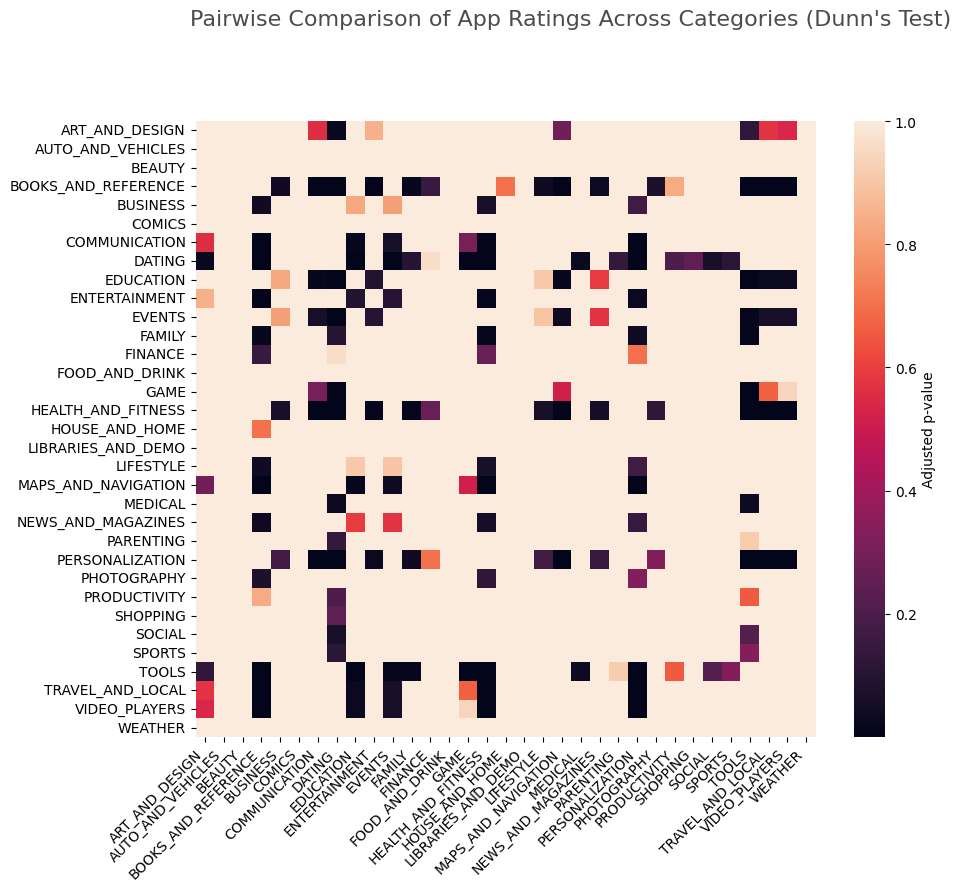

In [112]:
# Since the p-value is significant, we proceed with Dunn's post-hoc test
# to identify which specific category pairs are different.
# The heatmap visualizes these pairwise comparisons.
alpha = 0.05

if p_value < alpha:
    print("\nResult: The p-value is less than our significance level of 0.05.")
    print("Conclusion: We reject the null hypothesis. There is a statistically significant difference in median ratings across app categories.")
    print("\nProceeding with Dunn's Post-Hoc Test to identify specific differences...")

    dunn_results = sp.posthoc_dunn(
        df, val_col='Rating',
        group_col='Category',
        p_adjust='bonferroni'
    )

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        dunn_results,
        annot=False,
        cbar_kws={'label': 'Adjusted p-value'}
    )
    plt.suptitle(
        "Pairwise Comparison of App Ratings Across Categories (Dunn's Test)",
        fontsize=16,
        y=1.02,
        alpha=.7
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

else:
    print("\nResult: The p-value is greater than our significance level of 0.05.")
    print("Conclusion: We fail to reject the null hypothesis. There is no statistically significant evidence of a difference in median ratings across categories.")

**Conclusion:** The Kruskal-Wallis test yields a p-value of 0.0000, which is far below our significance level of 0.05. We therefore **reject the null hypothesis** and conclude that there is a statistically significant difference in median ratings across categories.

This result validates our strategy of imputing the missing `Rating` values with the **median rating of each app's respective category.**

**Insight from the Post-Hoc Test:** The heatmap reveals which category pairs have statistically different ratings. For example, the dark squares for the `DATING` category show that its ratings are significantly lower than most other categories (p < 0.05), confirming the anomaly mentioned in our executive summary."

In [113]:
# Calculate the median rating for each category.
category_medians = df.groupby('Category')['Rating'].transform('median')

# Fill the NaN values in the 'Rating' column using the calculated category medians.
df.fillna({'Rating': category_medians}, inplace=True)

### 6.3 Imputing Missing 'Size' Values

We will apply the same robust methodology to the missing `Size` values. We first investigate if the missingness is random and then test if app size differs by category to justify a grouped median imputation.

In [114]:
# Create a DataFrame of apps where 'Size' is null.
missing_size_df = df[df['Size'].isnull()]

# Display summary statistics for this group.
missing_size_df[['Reviews', 'Installs', 'Price']].describe()

,Reviews,Installs,Price
count,1.227000e+03,1.227000e+03,1227.000000
mean,8.758777e+05,3.563193e+07,0.228794
std,4.460045e+06,1.328043e+08,1.069216
min,0.000000e+00,0.000000e+00,0.000000
25%,6.944000e+03,5.000000e+05,0.000000
50%,5.198100e+04,5.000000e+06,0.000000
75%,3.584100e+05,1.000000e+07,0.000000
max,7.815831e+07,1.000000e+09,12.990000


In [115]:
# For comparison, create a DataFrame of apps that have a 'Size'.
has_size_df = df[df['Size'].notnull()]

# Display summary statistics for this group.
has_size_df[['Reviews', 'Installs', 'Price']].describe()

,Reviews,Installs,Price
count,8.432000e+03,8.432000e+03,8432.000000
mean,1.206553e+05,3.724212e+06,1.225972
std,9.363450e+05,2.482940e+07,18.028685
min,0.000000e+00,0.000000e+00,0.000000
25%,1.700000e+01,1.000000e+03,0.000000
50%,4.755000e+02,5.000000e+04,0.000000
75%,1.566725e+04,1.000000e+06,0.000000
max,4.489172e+07,1.000000e+09,400.000000


**Observation and Hypothesis for Missing 'Size':**

The analysis of apps with missing `Size` values (labeled as "Varies with device") reveals a pattern that is the inverse of what was observed for missing `Rating` values.

-   The **mean and median number of `Installs` and `Reviews` are significantly higher** for apps where the size "Varies with device".
-   This strongly suggests that this label is not used for small or unpopular apps. Instead, it is likely associated with **highly successful, complex applications**. These apps often use modern distribution methods like Android App Bundles, which deliver optimized packages tailored to each user's device, making a single, fixed size irrelevant.

Given this, the missingness in the `Size` column is also **not random**. It is systematically related to the app's complexity and popularity. Therefore, a context-aware imputation strategy is still the most appropriate choice. We will proceed by visualizing the boxplots & distributions and performing a Kruskal-Wallis test to confirm that app size differs significantly across categories, which will justify our plan to impute with the category-specific median.

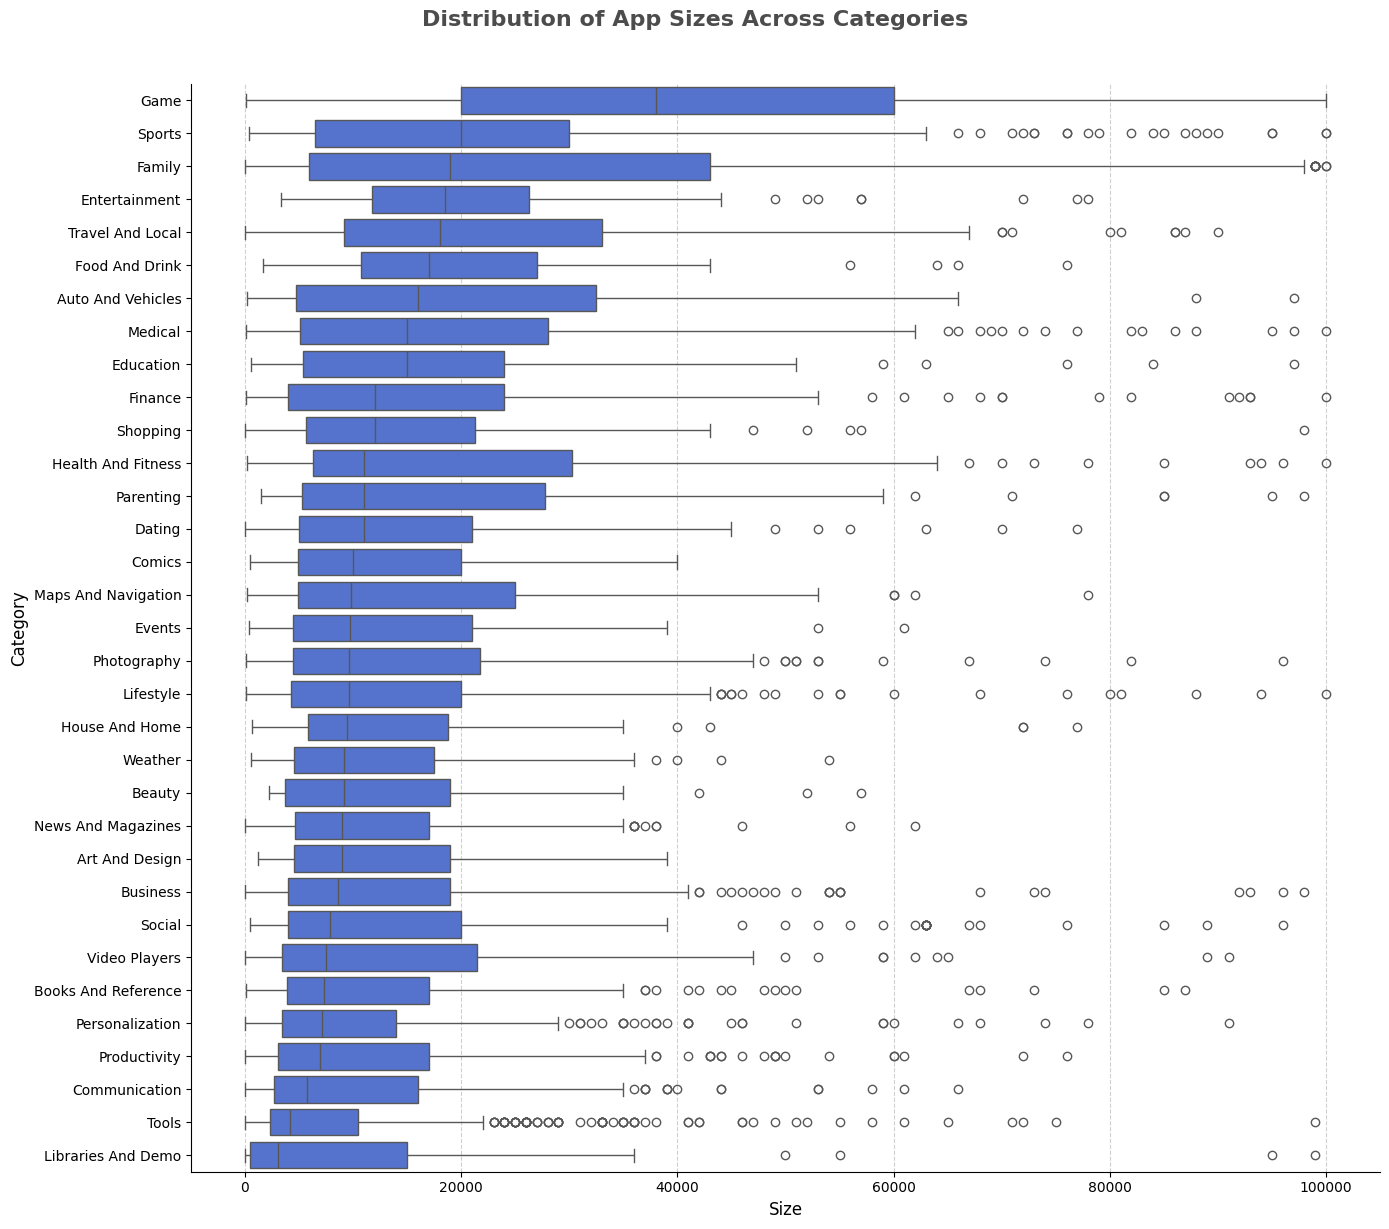

In [116]:
# Calculate the median rating for each category to create a sorted order for the plot.
size_order = df.dropna(subset=['Size']).groupby('Category')['Size'].median().sort_values(ascending=False).index

# Create the boxplot to visually inspect the distributions.
plt.figure(figsize=(14, 12))

sns.boxplot(
    data=df,
    x='Size',
    y='Category',
    order=size_order,
    color='royalblue'
)

# Add some polish and formatting
plt.suptitle('Distribution of App Sizes Across Categories', fontsize=16, fontweight='bold', y=1.02, alpha=.7)
plt.xlabel('Size', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()

ax = plt.gca()
tick_locations = ax.get_yticks()

formatted_labels = [label.replace('_', ' ').title() for label in size_order]

plt.yticks(ticks=tick_locations, labels=formatted_labels)

plt.tight_layout()
plt.show()

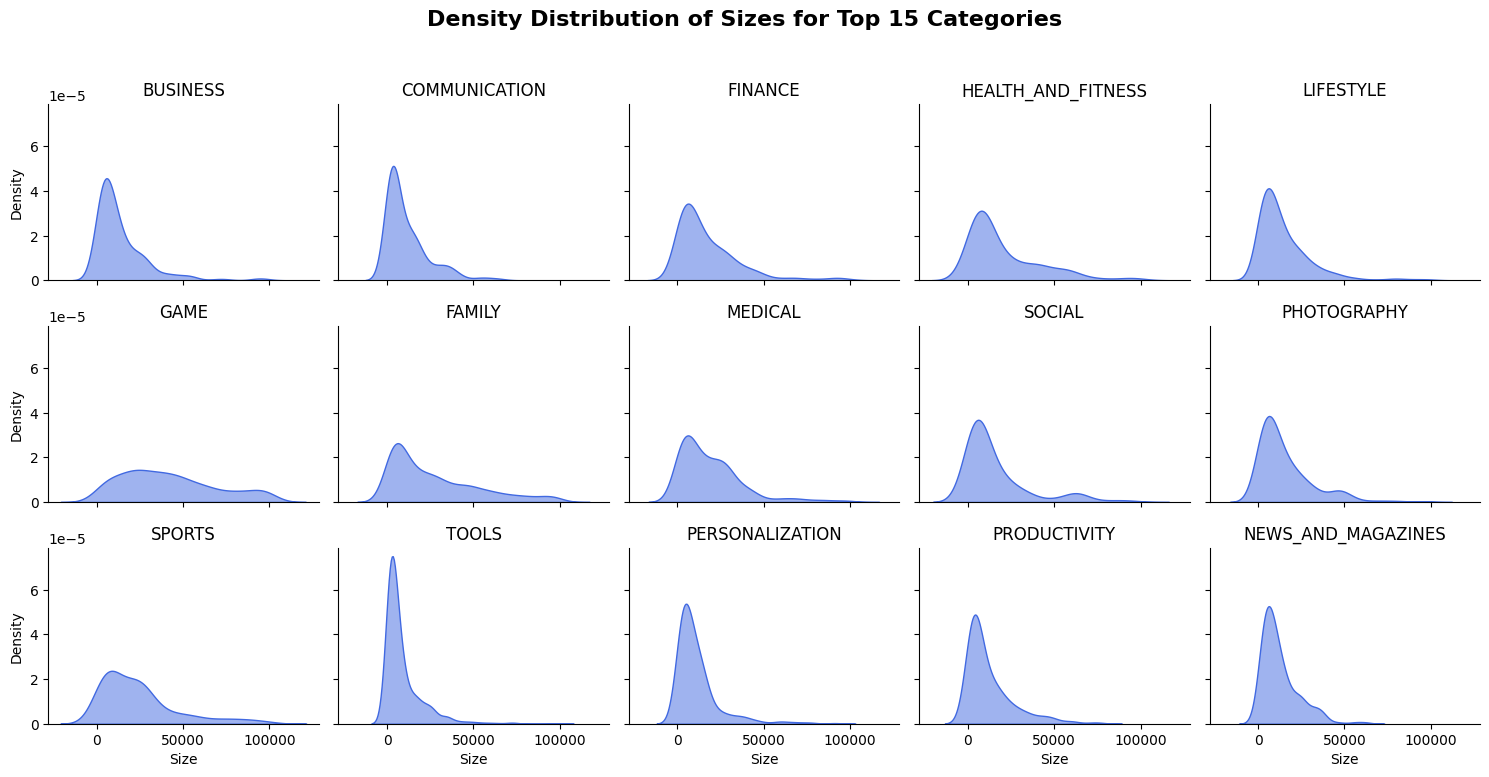

In [117]:
# For visual clarity, we'll focus on the top 15 categories by the number of apps.
top_categories = df['Category'].value_counts().nlargest(15).index

# Filter the DataFrame to only include these top categories.
df_top_cat = df[df['Category'].isin(top_categories)]

# Create a FacetGrid, which is ideal for creating a grid of similar plots.
# We'll arrange the plots in a grid with 5 columns.
g = sns.FacetGrid(df_top_cat, col="Category", col_wrap=5, height=2.5, aspect=1.2)

# Map a filled Kernel Density Estimate (KDE) plot onto each subplot of the grid.
# This provides a smooth representation of the size distributions.
g.map(sns.kdeplot, "Size", fill=True, alpha=0.5, color='royalblue')

# Add a descriptive super-title to the entire figure.
g.fig.suptitle('Density Distribution of Sizes for Top 15 Categories', y=1.03, fontsize=16, fontweight='bold')

# Set individual subplot titles to be the category name.
g.set_titles("{col_name}", size=12)

# Set the axis labels for clarity.
g.set_axis_labels("Size", "Density")

# Ensure the layout is clean and titles/labels do not overlap.
plt.tight_layout()
plt.show()

**Visual Observation:** The boxplot suggests that there are indeed differences in the median sizes across categories. However, to confirm this with statistical rigor, we will perform a **Kruskal-Wallis H-test**. This non-parametric test is appropriate because we cannot assume the data is normally distributed, as suggested by KDE plots.

- **Null Hypothesis (H₀):** The median sizes are the same across all app categories.

- **Alternative Hypothesis (H₁):** At least one app category has a different median size.

- **Significance Level (α):** 0.05

In [118]:
# Prepare the data for the Kruskal-Wallis test by creating a list of size series for each category.
size_by_category = [df['Size'][df['Category'] == cat].dropna() for cat in categories]

In [119]:
# Perform the Kruskal-Wallis H-Test and print the results
h_statistic, p_value = kruskal(*size_by_category)

print("--- Kruskal-Wallis H-Test Results ---")
print(f"H-statistic: {h_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

--- Kruskal-Wallis H-Test Results ---
H-statistic: 1507.0101
P-value: 0.0000



Result: The p-value is less than our significance level of 0.05.
Conclusion: We reject the null hypothesis. There is a statistically significant difference in median sizes across app categories.

Proceeding with Dunn's Post-Hoc Test to identify specific differences...


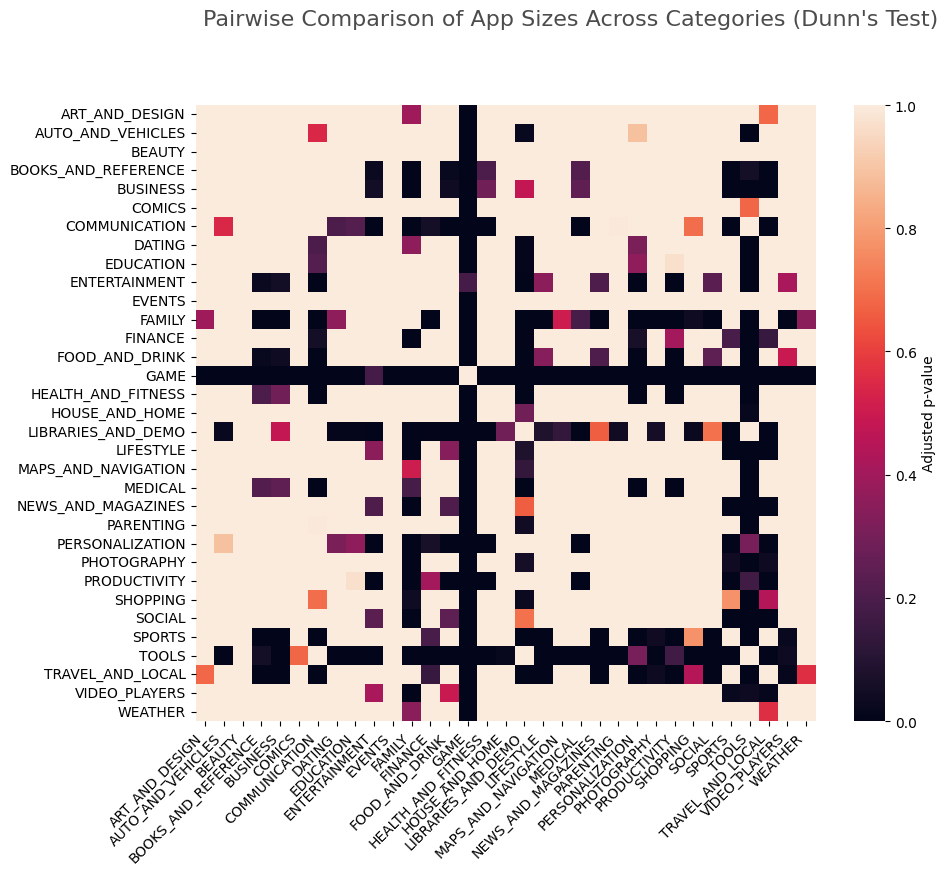

In [120]:
# Since the p-value is significant, we proceed with Dunn's post-hoc test
# to identify which specific category pairs are different.
# The heatmap visualizes these pairwise comparisons.
alpha = 0.05

if p_value < alpha:
    print("\nResult: The p-value is less than our significance level of 0.05.")
    print("Conclusion: We reject the null hypothesis. There is a statistically significant difference in median sizes across app categories.")
    print("\nProceeding with Dunn's Post-Hoc Test to identify specific differences...")

    dunn_results = sp.posthoc_dunn(
        df, val_col='Size', group_col='Category', p_adjust='bonferroni'
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        dunn_results, annot=False,
        cbar_kws={'label': 'Adjusted p-value'}
    )
    plt.suptitle(
        "Pairwise Comparison of App Sizes Across Categories (Dunn's Test)",
        fontsize=16,
        y=1,
        alpha=.7
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

else:
    print("\nResult: The p-value is greater than our significance level of 0.05.")
    print("Conclusion: We fail to reject the null hypothesis. There is no statistically significant evidence of a difference in median sizes across categories.")

**Conclusion:** The Kruskal-Wallis test yields a p-value of 0.0000, which is far below our significance level of 0.05. We therefore **reject the null hypothesis** and conclude that there is a statistically significant difference in median sizes across categories.

This result validates our strategy of imputing the missing `Size` values with the **median size of each app's respective category.**

In [121]:
# Calculate the median size for each category.
category_size_medians = df.groupby('Category')['Size'].transform('median')

# Fill the NaN values in the 'Size' column using the calculated category medians.
df.fillna({'Size': category_size_medians}, inplace=True)

### 6.4 Handling Final Minor Missing Values

Finally, we address the few remaining missing values in the `Type`, `Current Ver`, and `Android Ver` columns.

In [122]:
# Isolate and inspect the rows with the remaining missing values to understand their context.
df[df['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
9148,Command & Conquer: Rivals,FAMILY,4.3,0,19000.0,0,NaN,0.0,Everyone 10+,Strategy,Varies with device,Varies with device,28,6,2018


In [123]:
df[df['Current Ver'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
15,Learn To Draw Kawaii Characters,ART_AND_DESIGN,3.2,55,2700.0,5000,Free,0.00,Everyone,Art & Design,NaN,4.2 and up,6,6,2018
1553,Market Update Helper,LIBRARIES_AND_DEMO,4.1,20145,11.0,1000000,Free,0.00,Everyone,Libraries & Demo,NaN,1.5 and up,12,2,2013
6322,Virtual DJ Sound Mixer,TOOLS,4.2,4010,8700.0,500000,Free,0.00,Everyone,Tools,NaN,4.0 and up,10,5,2017
6803,BT Master,FAMILY,4.3,0,222.0,100,Free,0.00,Everyone,Education,NaN,1.6 and up,6,11,2016
7333,Dots puzzle,FAMILY,4.0,179,14000.0,50000,Paid,0.99,Everyone,Puzzle,NaN,4.0 and up,18,4,2018
7407,Calculate My IQ,FAMILY,4.3,44,7200.0,10000,Free,0.00,Everyone,Entertainment,NaN,2.3 and up,3,4,2017
7730,UFO-CQ,TOOLS,4.2,1,237.0,10,Paid,0.99,Everyone,Tools,NaN,2.0 and up,4,7,2016
10342,La Fe de Jesus,BOOKS_AND_REFERENCE,4.5,8,658.0,1000,Free,0.00,Everyone,Books & Reference,NaN,3.0 and up,31,1,2017


In [124]:
df[df['Android Ver'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Current Ver,Android Ver,Last_Updated_Day,Last_Updated_Month,Last_Updated_Year
4453,[substratum] Vacuum: P,PERSONALIZATION,4.4,230,11000.0,1000,Paid,1.49,Everyone,Personalization,4.4,NaN,20,7,2018
4490,Pi Dark [substratum],PERSONALIZATION,4.5,189,2100.0,10000,Free,0.00,Everyone,Personalization,1.1,NaN,27,3,2018


**Decision:** The number of affected rows (11 in total) is statistically insignificant (<0.2% of the dataset). Attempting to impute these categorical/text values would be unreliable. Therefore, the cleanest and most defensible approach is to remove these few rows entirely. This will not impact the overall data distribution or the conclusions of our analysis.

In [125]:
# Drop rows where 'Type', 'Current Ver', or 'Android Ver' are null.
df.dropna(subset=['Type', 'Current Ver', 'Android Ver'], inplace=True)

## 7. Saving the Cleaned Dataset

The data cleaning and preprocessing phase is now complete. The resulting DataFrame is clean, free of missing values, and has the correct data types. We will save this cleaned dataset to a new CSV file for the exploratory data analysis (EDA) phase.

In [126]:
# Save the cleaned DataFrame to 'googleplaystore_cleaned.csv'.
# `index=False` prevents pandas from writing the DataFrame index as a column.
df.to_csv('googleplaystore_cleaned.csv', index=False)

## 8. Exploratory Data Analysis (EDA)

With a clean and reliable dataset, we can now proceed with Exploratory Data Analysis. The goal of this phase is to understand the relationships between different features and to answer key questions about the app market. We will explore:

- The overall distribution of numerical and categorical data.
- Correlations between key metrics like `Rating`, `Reviews`, and `Installs`.
- The performance of different app categories.

### 8.1 Data Overview and Feature Separation

As a first step, we'll separate our features into numerical and categorical types for tailored analysis. We will also get a high-level view of the value distributions for our categorical features.

In [127]:
# Separate columns into numerical and categorical lists for easier analysis.
# We use select_dtypes() for a robust way to identify column types.
numeric_features = df.select_dtypes(include=['int64', 'Int64', 'float']).columns
categorical_features = df.select_dtypes(include=['object']).columns

print(f"Numeric features: {list(numeric_features)}")
print(f"Categorical features: {list(categorical_features)}")

Numeric features: ['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'Last_Updated_Day', 'Last_Updated_Month', 'Last_Updated_Year']
Categorical features: ['App', 'Category', 'Type', 'Content Rating', 'Genres', 'Current Ver', 'Android Ver']


In [128]:
# Display the percentage of unique values for each categorical feature.
# This helps identify columns with high cardinality (like 'App') and those with
# a few distinct groups (like 'Type').
for feature in categorical_features:
    print(df[feature].value_counts(normalize=True)*100)
    print('-'*30)

App
Cardio-FR                                             0.010365
List iptv FR                                          0.010365
PLMGSS FR                                             0.010365
Poop FR                                               0.010365
Fr. Daoud Lamei                                       0.010365
                                                        ...   
Pixel Draw - Number Art Coloring Book                 0.010365
Sketch - Draw & Paint                                 0.010365
U Launcher Lite – FREE Live Cool Themes, Hide Apps    0.010365
Coloring book moana                                   0.010365
Photo Editor & Candy Camera & Grid & ScrapBook        0.010365
Name: proportion, Length: 9648, dtype: float64
------------------------------
Category
FAMILY                 18.946932
GAME                    9.939884
TOOLS                   8.550995
BUSINESS                4.353234
MEDICAL                 4.094113
PRODUCTIVITY            3.876451
PERSONALIZATION   

### 8.2 Correlation Analysis

To understand the relationships between our key numerical metrics, we will visualize their correlations. A heatmap is an effective tool for this, as it provides a clear, color-coded overview of the strength and direction of these relationships.

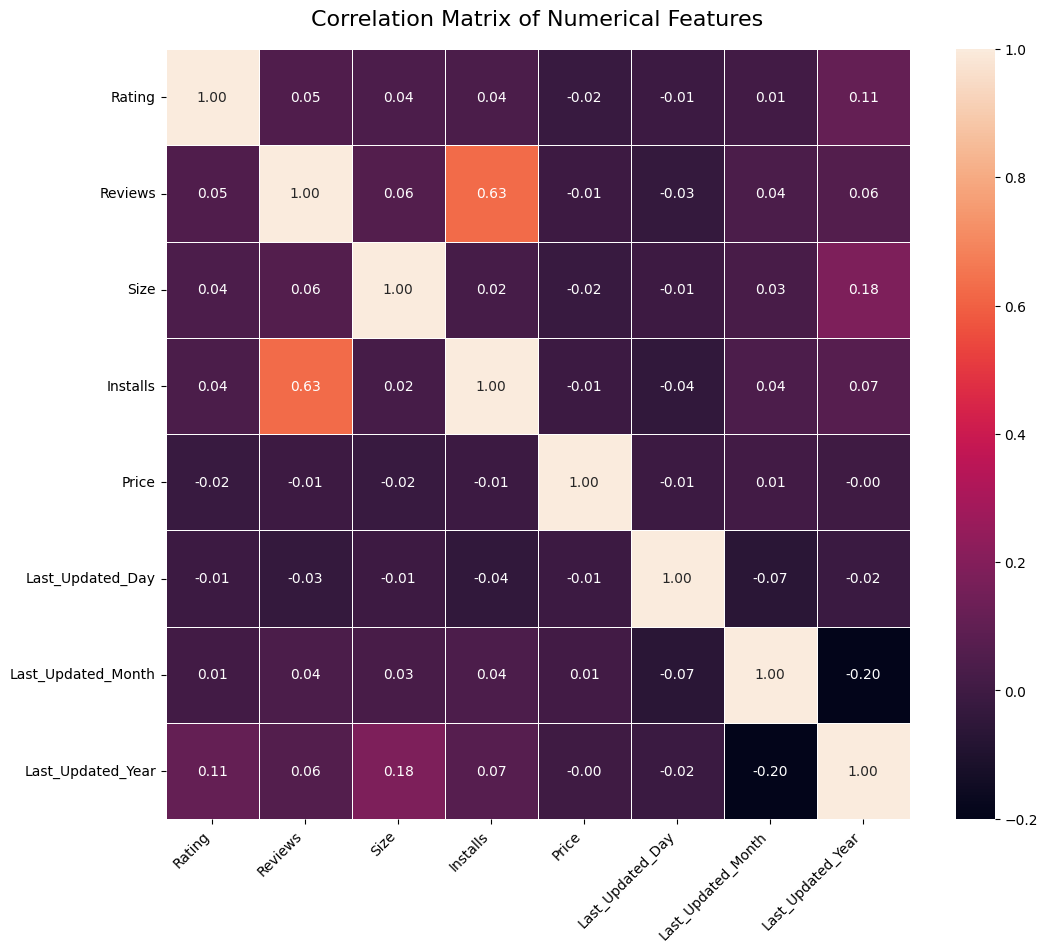

In [129]:
# Calculate the correlation matrix for all numeric features.
correlation_matrix = df[numeric_features].corr()

# Create the heatmap with annotations to show the correlation values.
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=.5)

plt.title('Correlation Matrix of Numerical Features', fontsize=16, y=1.02)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Insight from Correlation Matrix:**

There is a very strong positive correlation (0.64) between Reviews and Installs. This is intuitive: as more users install an app, the number of reviews it receives tends to increase.

Other correlations are weak, suggesting that factors like Size or Price do not have a strong linear relationship with Rating or Installs on their own.

### 8.3 Univariate Analysis: Feature Distributions

Next, we will examine the distribution of each feature individually to understand its characteristics.

#### Numerical Feature Distributions
We use Kernel Density Estimate (KDE) plots to visualize the shape of our numerical data. Because `Reviews`, `Installs` and `Price` are heavily skewed, we will use a log transformation in order to make them easier to interpret.

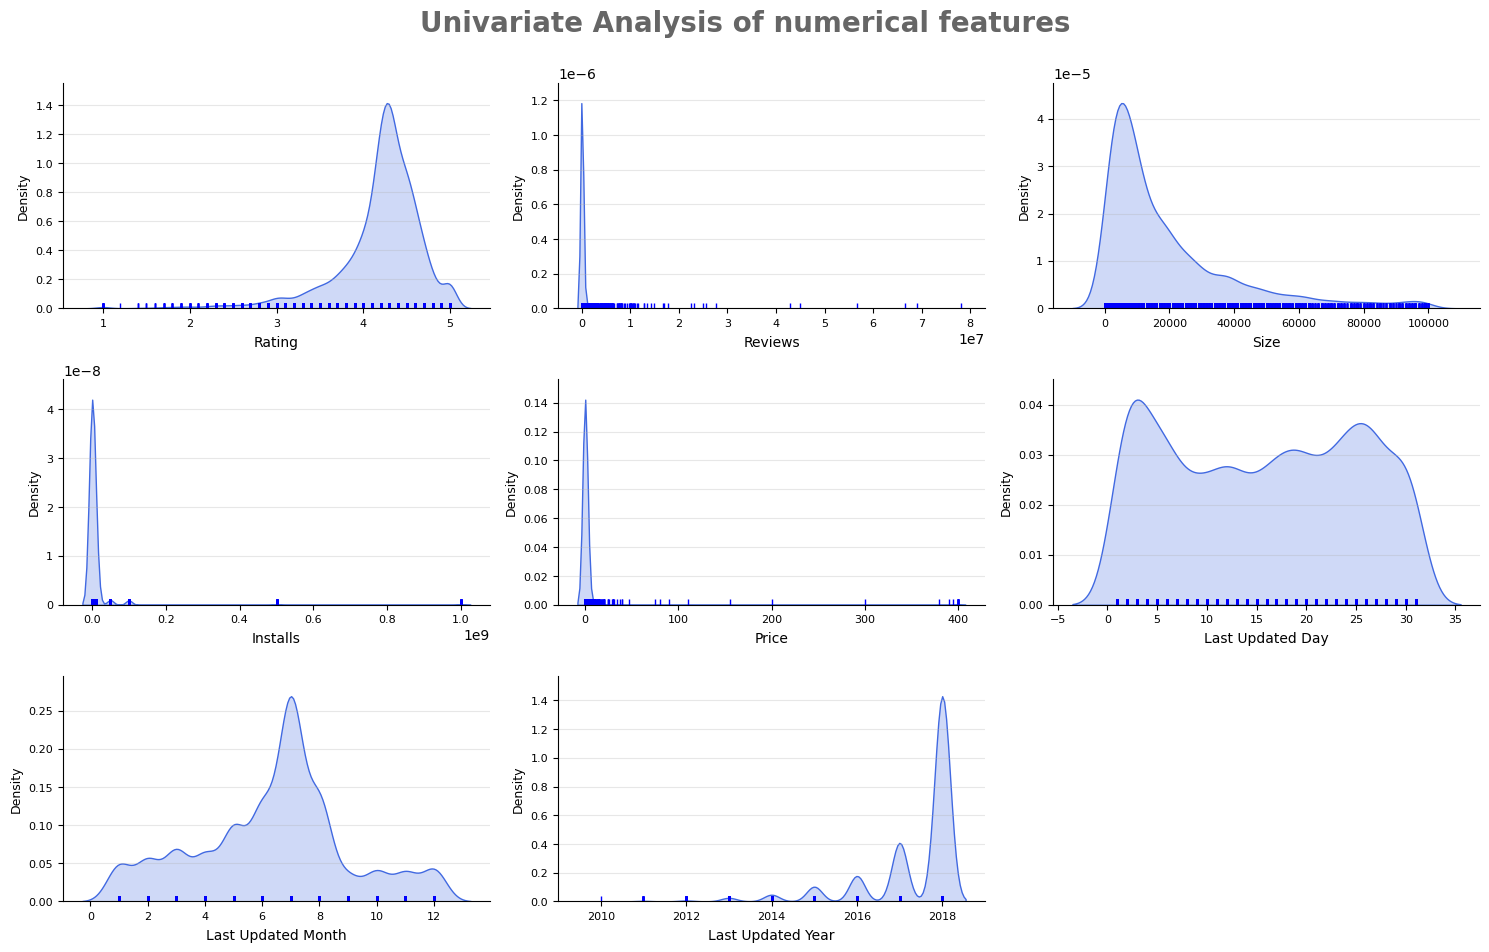

In [130]:
# Visualize the density of numerical data using a loop to create subplots.
# This provides a quick overview of the distribution (e.g., skewness, peaks) of each feature.
plt.figure(figsize=(15, 15))
plt.suptitle(
    'Univariate Analysis of numerical features',
    fontsize=20,
    fontweight='bold',
    alpha=0.6,
    y=1
)

for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i+1)

    sns.kdeplot(
        x=df[feature],
        fill=True,
        color='royalblue'
    )
    sns.rugplot(
        x=df[feature],
        color='blue'
    )

    sns.despine()

    plt.xlabel(
        feature.replace('_', ' ').title(),
        fontsize=10,
        labelpad=5
    )

    plt.ylabel('Density', fontsize=9)
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)

    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()

**Observation:** Most numerical features, particularly Reviews, Installs, and Price, are heavily right-skewed. This means that the majority of apps have low values for these metrics, while a few highly successful apps have extremely high values (long tail). The Rating feature, however, is left-skewed, indicating that most apps have high ratings.

#### Categorical Feature Distributions
For key categorical features like `Type` and `Content Rating`, we use count plots to see the frequency of each category.

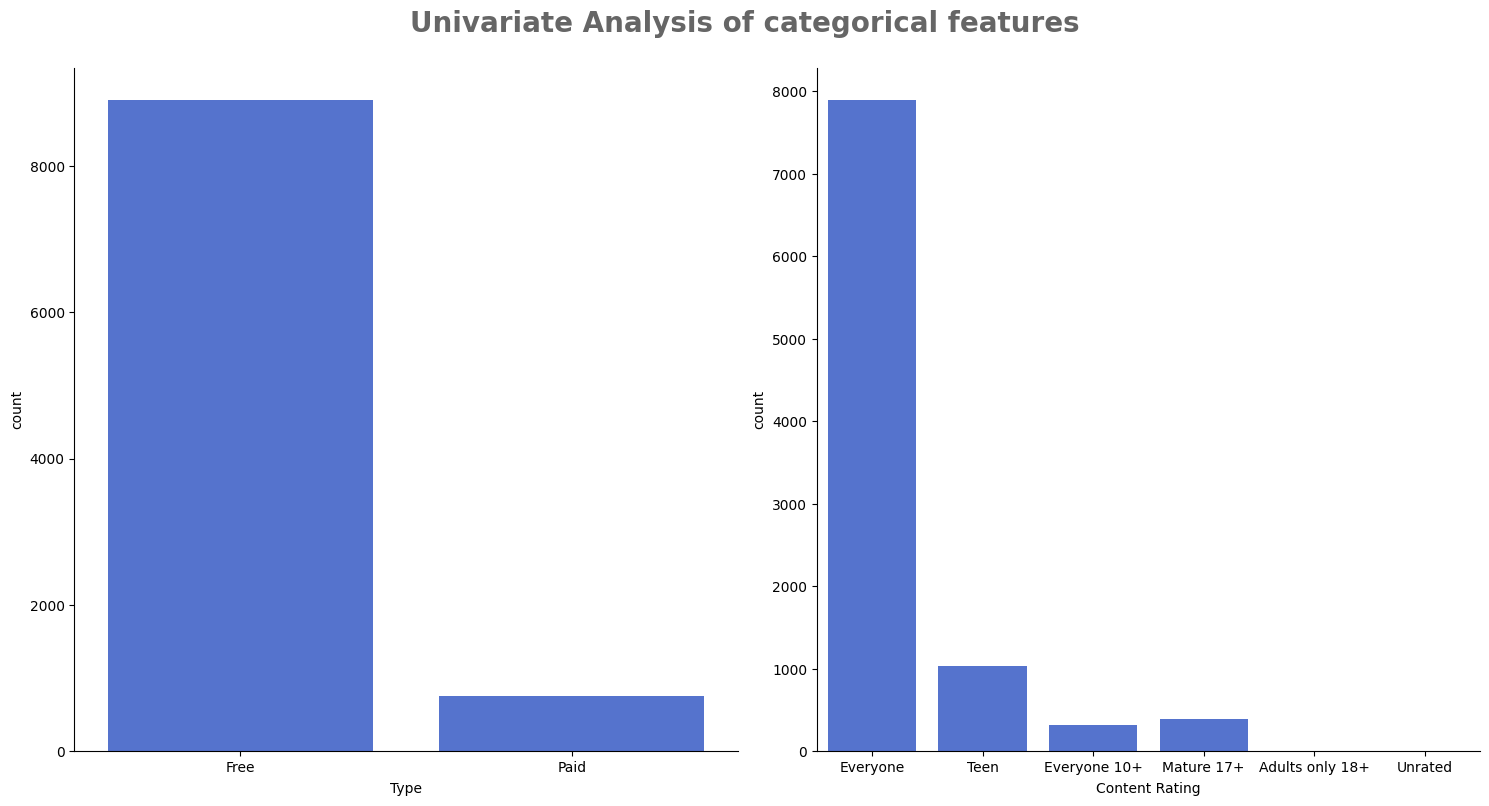

In [131]:
# Visualize the count of values for key categorical data.
# We select a subset of features for clarity, as plotting all would be overwhelming.
plt.figure(figsize=(15, 15))
plt.suptitle(
    'Univariate Analysis of categorical features',
    fontsize=20,
    fontweight='bold',
    alpha=0.6,
    y=1
)

categorical_features_for_visualization = ['Type', 'Content Rating']

for i, feature in enumerate(categorical_features_for_visualization):
    plt.subplot(2, 2, i+1)
    sns.countplot(
        x=df[feature],
        color='royalblue'
    )

    sns.despine()

    plt.xlabel(
        feature.replace('_', ' ').title(),
        fontsize=10,
        labelpad=5
    )
    plt.tight_layout()

**Observation:** The vast majority of apps on the Play Store are Free. The most common Content Rating is 'Everyone', followed by 'Teen'.

### 8.4 Answering Key Business Questions

Now we move from general exploration to answering specific, targeted questions about the app market.

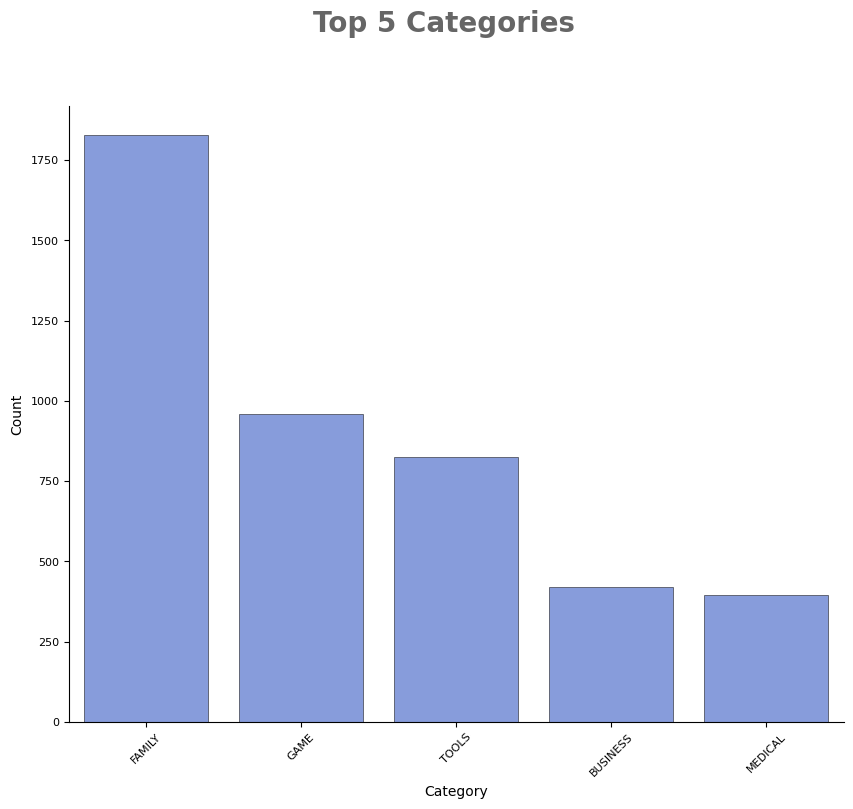

In [132]:
# Let's see which App Categories are most represented in the dataset by count.
# We'll visualize the top 5 for clarity.
plt.figure(figsize=(10, 8))
plt.suptitle(
    'Top 5 Categories',
    fontsize=20,
    fontweight='bold',
    alpha=0.6,
    y=1
)

sns.barplot(
    x=df['Category'].value_counts().head().index,
    y=df['Category'].value_counts().head().values,
    color='royalblue',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
)

sns.despine()

plt.xlabel('Category', fontsize=10, labelpad=5)
plt.ylabel('Count', fontsize=10, labelpad=5)

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.show()

**Observation:** The `Family` and `Game` categories have the highest number of apps available on the store, indicating these are the most crowded and competitive markets.

1. Which Category has the largest number of installations?
2. Which are the top 5 most installed apps in each popular category?
3. How many apps have 5 star rating?

#### 1. Which Category has the largest number of installations?
While the 'Family' category has the most apps, it may not be the category with the most user engagement. To determine market size by reach, we will analyze the total number of installations per category.

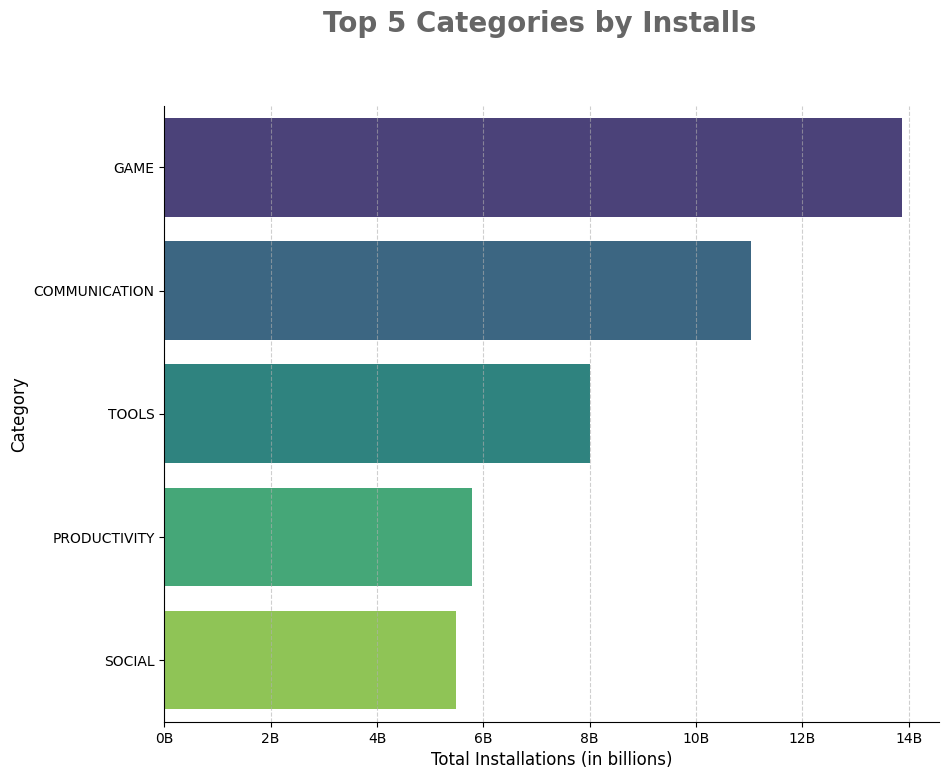

In [133]:
# Define a function to format large numbers into a more readable format (e.g., 35B for 35 billion).
def billions(x, pos):
    return f'{x*1e-9:1.0f}B'

# Group by category and sum the installs to find the most installed categories.
installs_by_category = df.groupby('Category')['Installs'].sum().sort_values(ascending=False)

top_n = 5

# We create the dataframe for plotting
installs_by_category_plot_df = installs_by_category.head(top_n).reset_index()
installs_by_category_plot_df.columns = ['Category', 'Total Installs']

plt.figure(figsize=(10, 8))
plt.suptitle(
    'Top 5 Categories by Installs',
    fontsize=20,
    fontweight='bold',
    alpha=0.6,
    y=1
)

# Create the bar plot
ax = sns.barplot(
    data=installs_by_category_plot_df,
    x='Total Installs',
    y='Category',
    hue='Category',
    orient='h',
    palette='viridis'
)

# Apply the custom formatter to the x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(billions))

plt.xlabel('Total Installations (in billions)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()

plt.show()

#### 2. Which are the top 5 most installed apps in each popular category?
To understand the key players in the largest markets, we will identify the top 5 most installed apps within the top 5 categories by installation count. This requires a more complex data manipulation workflow.

In [134]:
# Most popular categories based on installations
popular_categories = df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head().index

# Filter dataframe to include the top 5 categories
popular_categories_df = df[df['Category'].isin(popular_categories)].copy().reset_index(drop=True)

# Sort filtered df and groupby categories
popular_categories_df = popular_categories_df.sort_values('Installs', ascending=False).groupby('Category').head().reset_index(drop=True)

# Sort the dataframe with the top 5 most popular apps in each category by category and Installs
final_df = popular_categories_df.sort_values(['Category', 'Installs'], ascending=[True, False]).reset_index(drop=True)

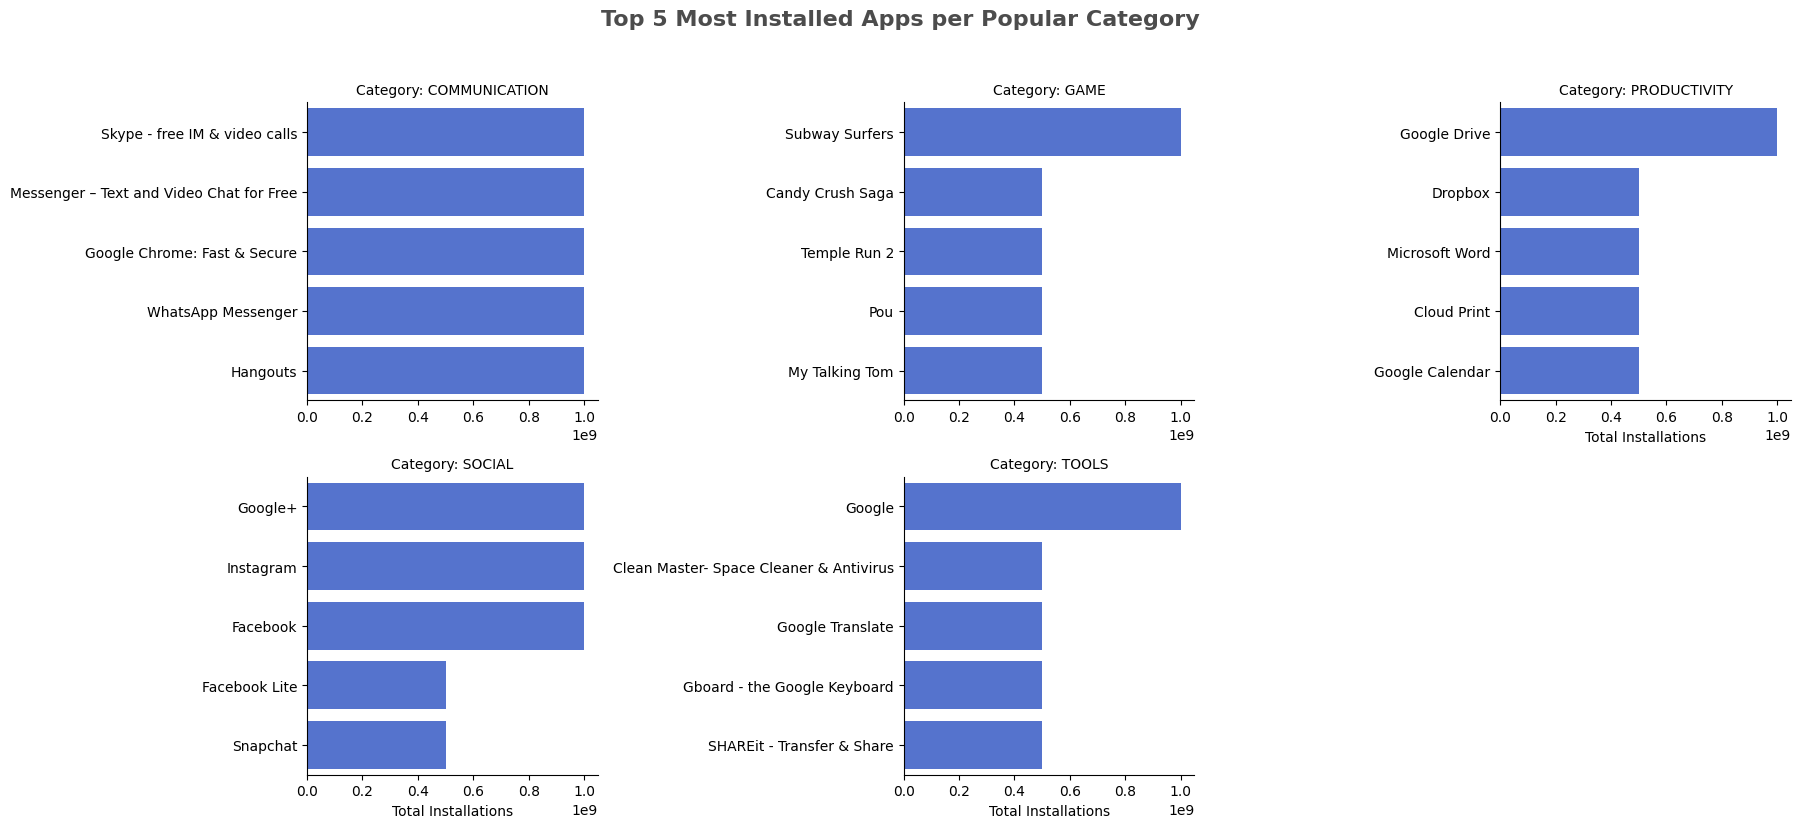

In [135]:
# Visualize the results as subplots
g = sns.catplot(
    data=final_df,
    x='Installs',
    y='App',
    col='Category',
    col_wrap=3,
    kind='bar',
    color='royalblue',
    height=4,
    aspect=1.5,
    sharex=False,
    sharey=False,
)

g.fig.suptitle('Top 5 Most Installed Apps per Popular Category', y=1.03, fontsize=16, fontweight='bold', alpha=0.7)
g.set_axis_labels('Total Installations', '')
g.set_titles("Category: {col_name}")
g.fig.tight_layout()

plt.show()

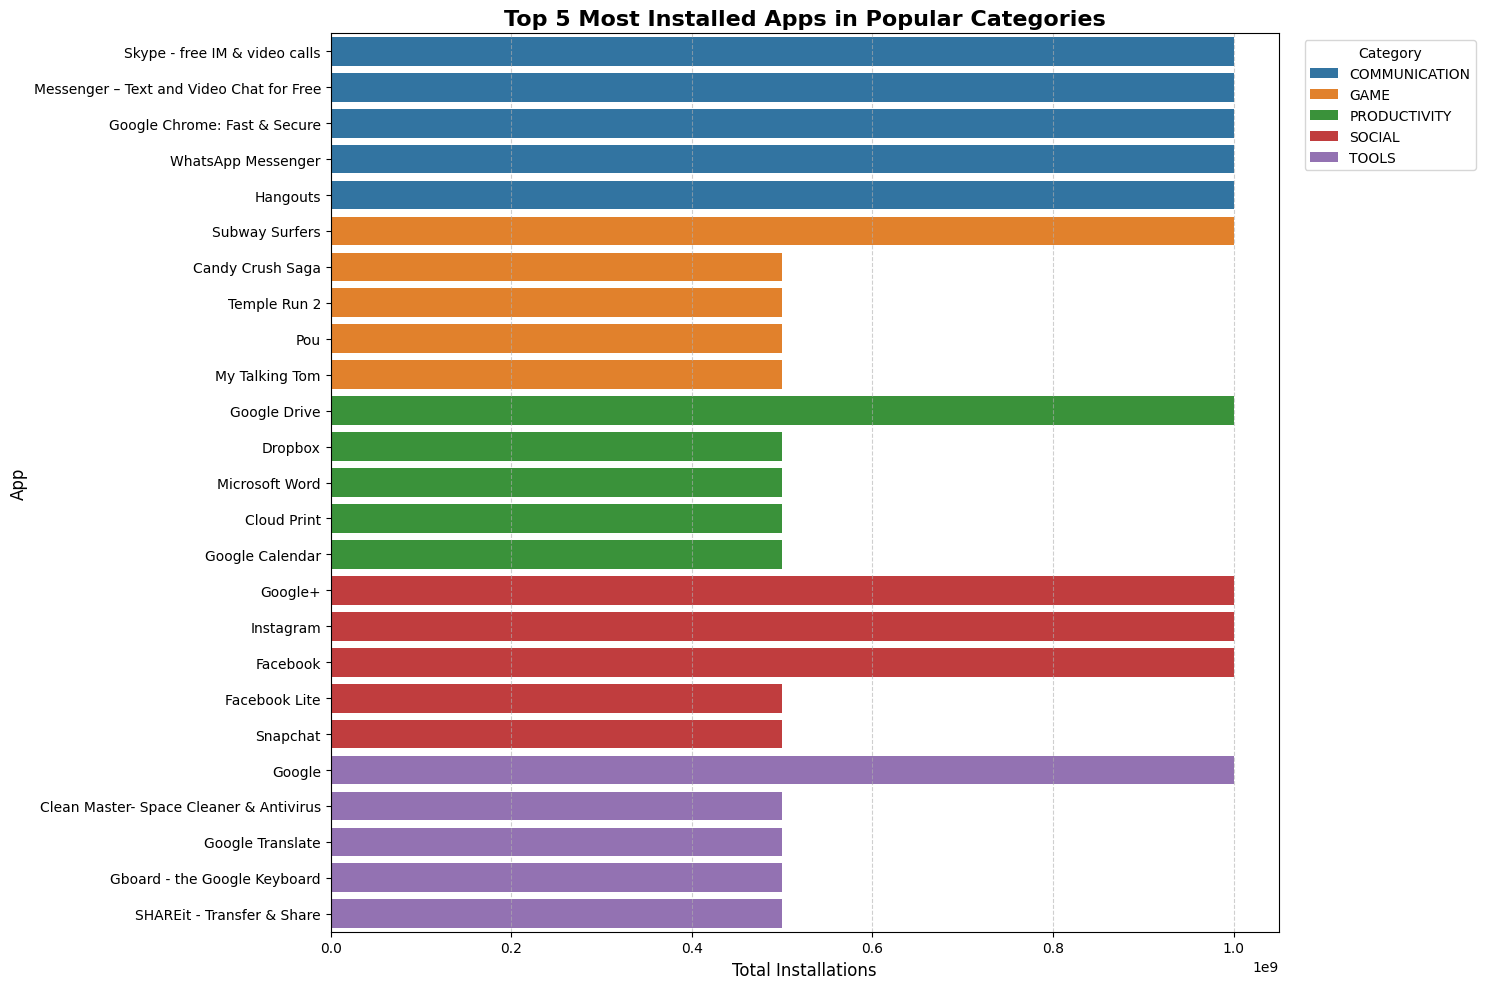

In [136]:
# Visualize the results as a single plot
plt.figure(figsize=(15, 10))
ax = sns.barplot(
    data=final_df,
    x='Installs',
    y='App',
    hue='Category',
    palette='tab10',
    dodge=False
)

plt.title('Top 5 Most Installed Apps in Popular Categories', fontsize=16, fontweight='bold')
plt.xlabel('Total Installations', fontsize=12)
plt.ylabel('App', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

#### 3. How many apps have a perfect 5-star rating?
Perfect ratings are rare and can be an indicator of either exceptional quality or potentially low review counts. Let's quantify how many apps achieve this.

In [137]:
# Create the mask
mask = df['Rating'] == 5

# Apply the mask to our df
five_star_apps_df = df[mask]

# Check the length of the filtered df
print(f"Number of apps with 5 star rating: {len(five_star_apps_df)}")

Number of apps with 5 star rating: 271


### 8.5 Bonus Analysis: Perfect Ratings

Let's dig deeper into the apps with perfect 5-star ratings.

#### Which category has the most 5-star apps?
We can visualize the distribution of these top-rated apps across categories to see if certain genres are more likely to receive perfect scores.



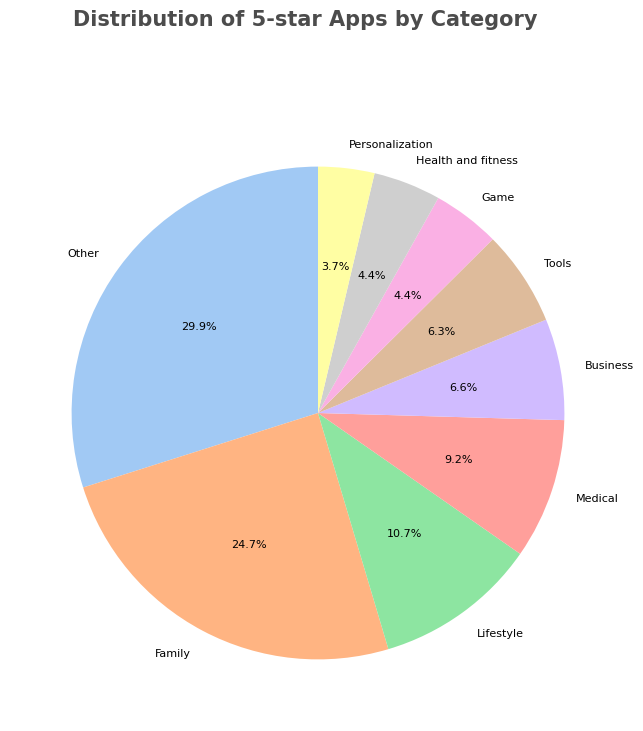

In [138]:
# Group by category & count the Apps with 5-star rating
five_star_apps_by_category_df = five_star_apps_df.groupby('Category')['App'].count()

# Grouping smaller slices into an 'Other' category is a great practice for pie chart readability.
# Categories with 7 and less 5-star apps will pass to 'Other' category
threshold = 8
other_categories_mask = five_star_apps_by_category_df <= threshold

# Create a new Series with the main categories
main_categories = five_star_apps_by_category_df[~other_categories_mask]
main_categories_list = main_categories.index.to_list()
main_categories_list_formatted = [category.capitalize().replace('_', ' ') for category in main_categories_list]
main_categories = pd.Series(main_categories.values, index=main_categories_list_formatted)

# Sum the 'Other' categories and add it to the main Series
other_categories_sum = five_star_apps_by_category_df[other_categories_mask].sum()
main_categories['Other'] = other_categories_sum

# Rename and Sort for a cleaner pie chart layout
five_star_apps_by_category_df = main_categories.sort_values(ascending=False)


# Visualize the results with a pie chart to show proportional distribution.
plt.figure(figsize=(10, 8))
plt.suptitle(
    'Distribution of 5-star Apps by Category',
    fontsize=15,
    fontweight='bold',
    alpha=0.7,
    y=1
)

plt.pie(
    five_star_apps_by_category_df,
    labels=five_star_apps_by_category_df.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    textprops={'fontsize': 8}
)
plt.show()

**Insight:** The `Family`, `Lifestyle` and `Medical` categories have the highest proportion of apps with a 5-star rating. This might suggest that apps in these categories serve a very specific, satisfied user base, or that they have fewer reviews, making a perfect score easier to maintain.